In [5]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [6]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [7]:
df['TOTAL_REVENUE'].isnull().sum()*100/df['TOTAL_REVENUE'].isnull().count()

14.20911528150134

In [8]:
df['TOTAL_EXPENDITURE'].isnull().sum()*100/df['TOTAL_EXPENDITURE'].isnull().count()

14.20911528150134

In [9]:
#reduce blank values by using forward, then backward linear interpolation

def interpolate_by_state (df, column):
    df[column] = df.groupby('STATE')[column].apply(lambda group: group.interpolate())
    df[column] = df.groupby('STATE')[column].apply(lambda group: group.interpolate(method ='linear', limit_direction ='backward'))

interpolate_by_state(df, 'TOTAL_REVENUE')
interpolate_by_state(df, 'TOTAL_EXPENDITURE')

In [10]:
df['TOTAL_REVENUE'].isnull().sum()*100/df['TOTAL_REVENUE'].isnull().count()

10.79088471849866

In [11]:
df['TOTAL_EXPENDITURE'].isnull().sum()*100/df['TOTAL_EXPENDITURE'].isnull().count()

10.79088471849866

In [12]:
#remove rows where values are still null after interpolation (these are geographic regions
#where we have no data to interpolate from)

df = df[pd.notnull(df['TOTAL_EXPENDITURE'])]
df = df[pd.notnull(df['TOTAL_REVENUE'])]

In [13]:
df['TOTAL_REVENUE'].isnull().sum()*100/df['TOTAL_REVENUE'].isnull().count()

0.0

In [14]:
df['TOTAL_EXPENDITURE'].isnull().sum()*100/df['TOTAL_EXPENDITURE'].isnull().count()

0.0

In [15]:
#after dropping blank values, we still have 1331 rows, which is 89.2%
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1331 non-null object
STATE                           1331 non-null object
YEAR                            1331 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1331 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1331 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1218 non-null float64
GRADES_KG_G                     1229 non-null float64
GRADES_4_G                      1229 non-null float64
GRADES_8_G                      1

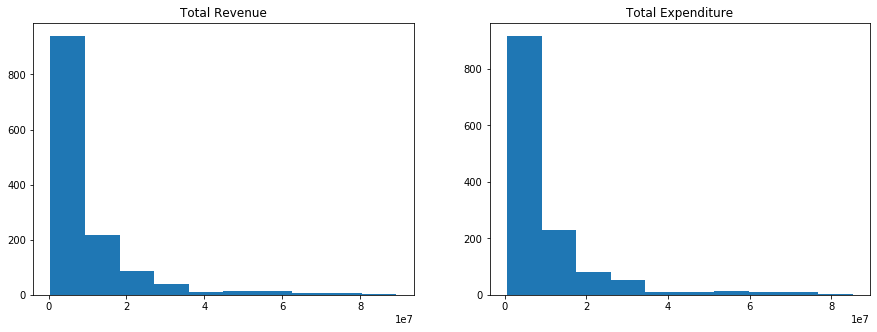

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [21]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df['TOTAL_REVENUE'])
plt.title('Total Revenue')

plt.subplot(1,2,2)
plt.hist(df['TOTAL_EXPENDITURE'])
plt.title('Total Expenditure')

plt.show()

plt.figure(figsize = (15,5))


QUESTION 1: Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?
        
ANSWER: Outliers show below, and we can tell from the histograms above that the data is not distributed normally.

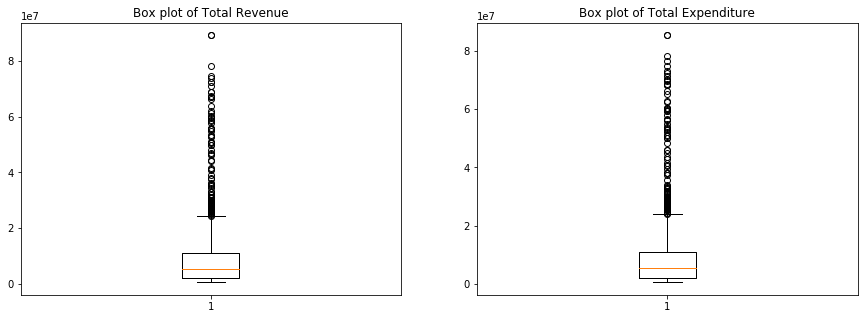

In [17]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(df['TOTAL_REVENUE'])
plt.title('Box plot of Total Revenue')

plt.subplot(1,2,2)
plt.boxplot(df['TOTAL_EXPENDITURE'])
plt.title('Box plot of Total Expenditure')

plt.show()

In [19]:
# Statistical look at the outliers for these TOTAL_REVENUE shows 31 outliers 
q_rev75, q_rev25 = np.percentile(df["TOTAL_REVENUE"], [75 ,25])
iqr_rev = q_rev75 - q_rev25

for threshold in np.arange(1,5,0.5):
    min_val_rev = q_rev25 - (iqr_rev*threshold)
    max_val_rev = q_rev75 + (iqr_rev*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df["TOTAL_REVENUE"] > max_val_rev) 
                      | (df["TOTAL_REVENUE"] < min_val_rev))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 146
The score threshold is: 1.5
Number of outliers is: 111
The score threshold is: 2.0
Number of outliers is: 76
The score threshold is: 2.5
Number of outliers is: 53
The score threshold is: 3.0
Number of outliers is: 47
The score threshold is: 3.5
Number of outliers is: 42
The score threshold is: 4.0
Number of outliers is: 38
The score threshold is: 4.5
Number of outliers is: 31


In [20]:
# Statistical look at the outliers for these TOTAL_EXPENDITURE shows 38 outliers 
q_exp75, q_exp25 = np.percentile(df["TOTAL_EXPENDITURE"], [75 ,25])
iqr_exp = q_exp75 - q_exp25

for threshold in np.arange(1,5,0.5):
    min_val_exp = q_exp25 - (iqr_exp*threshold)
    max_val_exp = q_exp75 + (iqr_exp*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df["TOTAL_EXPENDITURE"] > max_val_exp) 
                      | (df["TOTAL_EXPENDITURE"] < min_val_exp))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 158
The score threshold is: 1.5
Number of outliers is: 116
The score threshold is: 2.0
Number of outliers is: 81
The score threshold is: 2.5
Number of outliers is: 58
The score threshold is: 3.0
Number of outliers is: 52
The score threshold is: 3.5
Number of outliers is: 45
The score threshold is: 4.0
Number of outliers is: 41
The score threshold is: 4.5
Number of outliers is: 38


QUESTION 2: If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

ANSWER 2: The IQR log calculations below show that outliers are eliminated with a log transform

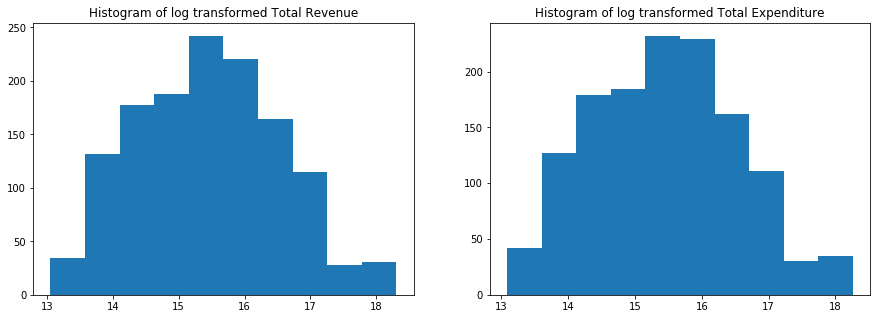

In [23]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(np.log(df['TOTAL_REVENUE']))
plt.title('Histogram of log transformed Total Revenue')

plt.subplot(1,2,2)
plt.hist(np.log(df['TOTAL_EXPENDITURE']))
plt.title('Histogram of log transformed Total Expenditure')

plt.show()

In [41]:
#checking to see if log transform eliminates outliers for TOTAL_REVENUE
qrev_log75, qrev_log25 = np.percentile(np.log(df["TOTAL_REVENUE"]), [75 ,25])
iqr_rev_log = qrev_log75 - qrev_log25

for threshold in np.arange(1,5,0.5):
    min_rev_log = qrev_log25 - (iqr_rev_log*threshold)
    max_rev_log = qrev_log75 + (iqr_rev_log*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(df["TOTAL_REVENUE"]) > max_rev_log) 
                      | (np.log(df["TOTAL_REVENUE"]) < min_rev_log))[0]))
    ))
    
df['TOTAL_REVENUE_LOG'] = np.log(df['TOTAL_REVENUE'])

The score threshold is: 1.0
Number of outliers is: 23
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [42]:
#checking to see if log transform eliminates outliers for TOTAL_EXPENDITURE
qexp_log75, qexp_log25 = np.percentile(np.log(df["TOTAL_EXPENDITURE"]), [75 ,25])
iqr_exp_log = qexp_log75 - qexp_log25

for threshold in np.arange(1,5,0.5):
    min_exp_log = qexp_log25 - (iqr_exp_log*threshold)
    max_exp_log = qexp_log75 + (iqr_exp_log*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(df["TOTAL_EXPENDITURE"]) > max_exp_log) 
                      | (np.log(df["TOTAL_EXPENDITURE"]) < min_exp_log))[0]))
    ))
    
df['TOTAL_EXPENDITURE_LOG'] = np.log(df['TOTAL_EXPENDITURE'])

The score threshold is: 1.0
Number of outliers is: 29
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


QUESTION 3: Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

ANSWER 3: The TOTAL_DEFICIT variable does contain outliers, and these can be transformed using the log tranform approach. This results in 0 outliers.

In [28]:
df['TOTAL_DEFICIT'] = df['TOTAL_REVENUE']-df['TOTAL_EXPENDITURE']

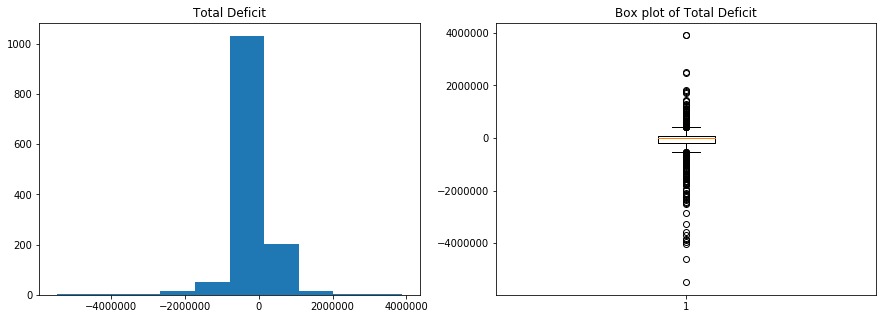

In [35]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df['TOTAL_DEFICIT'])
plt.title('Total Deficit')

plt.subplot(1,2,2)
plt.boxplot(df['TOTAL_DEFICIT'])
plt.title('Box plot of Total Deficit')
plt.show()

In [37]:
# Statistical look at the outliers for these TOTAL_DEFICIT shows 61 outliers 
q_def75, q_def25 = np.percentile(df["TOTAL_DEFICIT"], [75 ,25])
iqr_def = q_def75 - q_def25

for threshold in np.arange(1,5,0.5):
    min_val_def = q_def25 - (iqr_def*threshold)
    max_val_def = q_def75 + (iqr_def*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df["TOTAL_DEFICIT"] > max_val_def) 
                      | (df["TOTAL_DEFICIT"] < min_val_def))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 275
The score threshold is: 1.5
Number of outliers is: 202
The score threshold is: 2.0
Number of outliers is: 151
The score threshold is: 2.5
Number of outliers is: 117
The score threshold is: 3.0
Number of outliers is: 100
The score threshold is: 3.5
Number of outliers is: 85
The score threshold is: 4.0
Number of outliers is: 78
The score threshold is: 4.5
Number of outliers is: 61


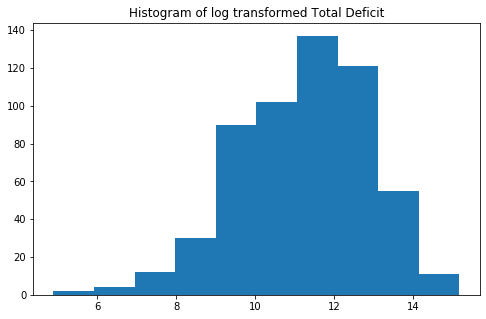

In [38]:
plt.figure(figsize = (8,5))

plt.hist(np.log(df['TOTAL_DEFICIT']))
plt.title('Histogram of log transformed Total Deficit')

plt.show()

In [40]:
#checking to see if log transform eliminates outliers for TOTAL_DEFICIT
qdef_log75, qdef_log25 = np.percentile(np.log(df["TOTAL_DEFICIT"]), [75 ,25])
iqr_def_log = qdef_log75 - qdef_log25

for threshold in np.arange(1,5,0.5):
    min_def_log = qdef_log25 - (iqr_def_log*threshold)
    max_def_log = qdef_log75 + (iqr_def_log*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(df["TOTAL_DEFICIT"]) > max_def_log) 
                      | (np.log(df["TOTAL_DEFICIT"]) < min_def_log))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 0
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


QUESTION 4: Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

ANSWER 4: There are still 5 outliers. What is the best way to deal with these since the initial values were already log transformed?

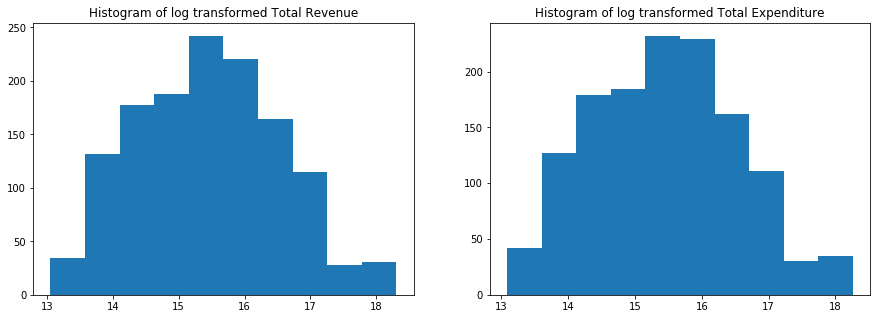

In [45]:
#verifying that newly created variables are correct
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df['TOTAL_REVENUE_LOG'])
plt.title('Histogram of log transformed Total Revenue')

plt.subplot(1,2,2)
plt.hist(df['TOTAL_EXPENDITURE_LOG'])
plt.title('Histogram of log transformed Total Expenditure')

plt.show()

In [46]:
df['TOTAL_DEFICIT_LOG'] = df['TOTAL_REVENUE_LOG'] - df['TOTAL_EXPENDITURE_LOG']

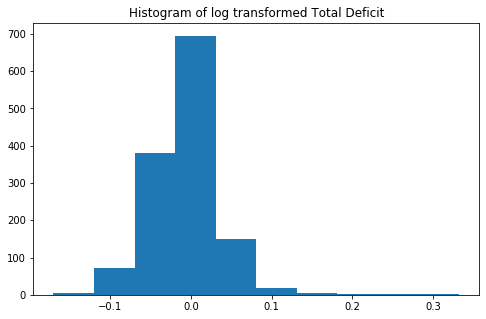

In [49]:
plt.figure(figsize = (8,5))

plt.hist(df['TOTAL_DEFICIT_LOG'])
plt.title('Histogram of log transformed Total Deficit')

plt.show()

In [50]:
# Statistical look at the outliers for these TOTAL_DEFICIT_LOG shows 5 outliers remain even after
#creating the log version of deficit
qdef_log75, qdef_log25 = np.percentile(df["TOTAL_DEFICIT_LOG"], [75 ,25])
iqr_def_log = qdef_log75 - qdef_log25

for threshold in np.arange(1,5,0.5):
    min_def_log = qdef_log25 - (iqr_def_log*threshold)
    max_def_log = qdef_log75 + (iqr_def_log*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df["TOTAL_DEFICIT_LOG"] > max_def_log) 
                      | (df["TOTAL_DEFICIT_LOG"] < min_def_log))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 130
The score threshold is: 1.5
Number of outliers is: 53
The score threshold is: 2.0
Number of outliers is: 22
The score threshold is: 2.5
Number of outliers is: 13
The score threshold is: 3.0
Number of outliers is: 10
The score threshold is: 3.5
Number of outliers is: 8
The score threshold is: 4.0
Number of outliers is: 8
The score threshold is: 4.5
Number of outliers is: 5


QUESTION 5: Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

ANSWER 5: Values are vastly different and variability has decreased significantly.

In [65]:
#describe TOTAL_REVENUE and TOTAL_REVENUE_LOG

pd.set_option('float_format', '{:f}'.format)

print('Stats for TOTAL_REVENUE \n')
print(df['TOTAL_REVENUE'].describe())
print('\nStats for TOTAL_REVENUE_LOG \n')
print(df['TOTAL_REVENUE_LOG'].describe())

Stats for TOTAL_REVENUE 

count       1331.000000
mean     9246803.869271
std     12003497.149168
min       465650.000000
25%      2200842.500000
50%      5169926.000000
75%     11099001.000000
max     89217262.000000
Name: TOTAL_REVENUE, dtype: float64

Stats for TOTAL_REVENUE_LOG 

count   1331.000000
mean      15.454379
std        1.079683
min       13.051190
25%       14.604347
50%       15.458369
75%       16.222366
max       18.306585
Name: TOTAL_REVENUE_LOG, dtype: float64


In [66]:
#describe TOTAL_EXPENDITURE and TOTAL_EXPENDITURE_LOG

pd.set_option('float_format', '{:f}'.format)

print('Stats for TOTAL_EXPENDITURE \n')
print(df['TOTAL_EXPENDITURE'].describe())
print('\nStats for TOTAL_EXPENDITURE_LOG \n')
print(df['TOTAL_EXPENDITURE_LOG'].describe())

Stats for TOTAL_EXPENDITURE 

count       1331.000000
mean     9342417.208114
std     12207522.362845
min       481665.000000
25%      2176975.000000
50%      5298267.000000
75%     10873165.500000
max     85320133.000000
Name: TOTAL_EXPENDITURE, dtype: float64

Stats for TOTAL_EXPENDITURE_LOG 

count   1331.000000
mean      15.459736
std        1.083706
min       13.085004
25%       14.593447
50%       15.482890
75%       16.201808
max       18.261921
Name: TOTAL_EXPENDITURE_LOG, dtype: float64


QUESTION 6: If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

ANSWER 6: It seems more accurate to create the variable from the true (original) data first and then transform it.